In [3]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory

In [4]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [5]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/1906_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

In [6]:
arctic_df = encode_tulabel(arctic_df)
arctic_df = arctic_df[~arctic_df.duplicated(subset="latitude")]

In [7]:
global_pkl = os.path.join(parent_dir, "data/processed/Mashayek2022/input_microstructure.pkl")
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

In [42]:
def stereo_plot(merged_df, variable, name_var):
    """
    Creates a polar stereographic plot of longitude and latitude with colored
    residuals.

    Parameters:
        merged_df (pd.DataFrame): A dataframe containing longitude and
            latitude information.
        variable (np.ndarray): An array of values representing the variable
            of interest.
        name_var (str): The name of the variable for the colorbar label.

    Returns:
        None

    Example:
        # Assuming merged_df is a dataframe with columns 'longitude' and
        # 'latitude' variable is an array of values, and name_var is a string
        stereo_plot(merged_df, variable, name_var)
    """

    # Create a polar stereographic projection centered on the Arctic pole
    projection = ccrs.NorthPolarStereo(central_longitude=0)

    # Create a figure and axes using the polar stereographic projection
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})

    # Plot longitude and latitude with colored residuals
    sc = ax.scatter(merged_df['longitude'], merged_df['latitude'],
                    c=(variable), # vmin=0, vmax=1,
                    cmap='viridis', transform=ccrs.PlateCarree())

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label=name_var)

    # Set map extent to focus on the Arctic region
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # Add map features
    ax.coastlines()
    ax.gridlines()

    # Set plot title and labels
    plt.title(f"{name_var} based on cruise location")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()



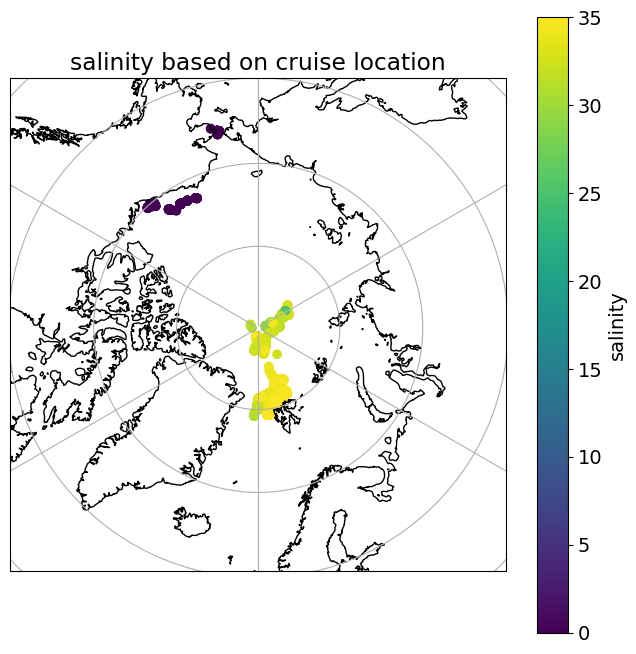

In [19]:
stereo_plot(arctic_df, arctic_df["S"], "salinity")

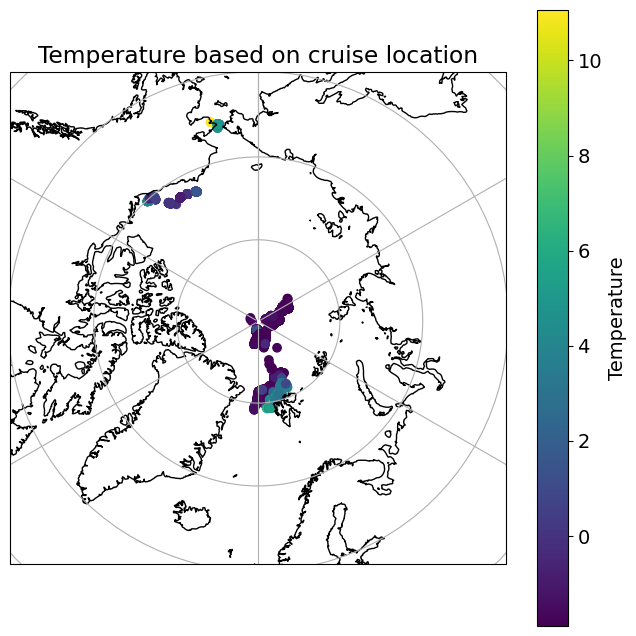

In [20]:
stereo_plot(arctic_df, arctic_df["T"], "Temperature")

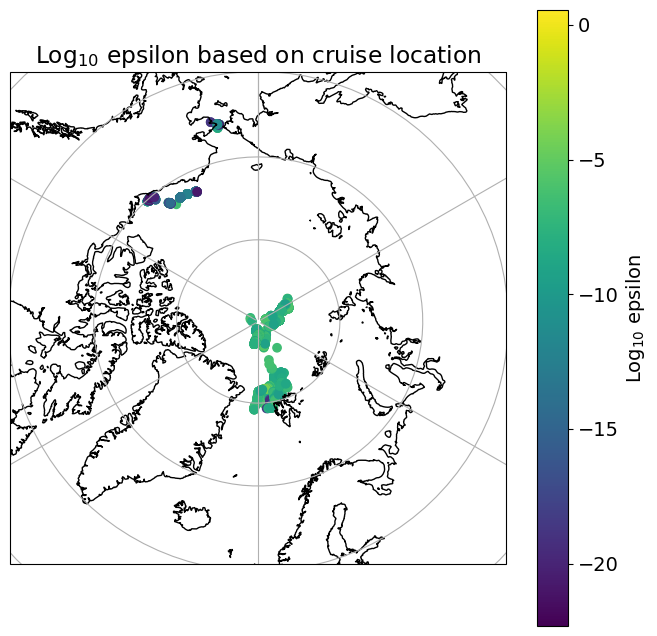

In [21]:
stereo_plot(arctic_df, arctic_df["log_eps"], "Log$_{10}$ epsilon")

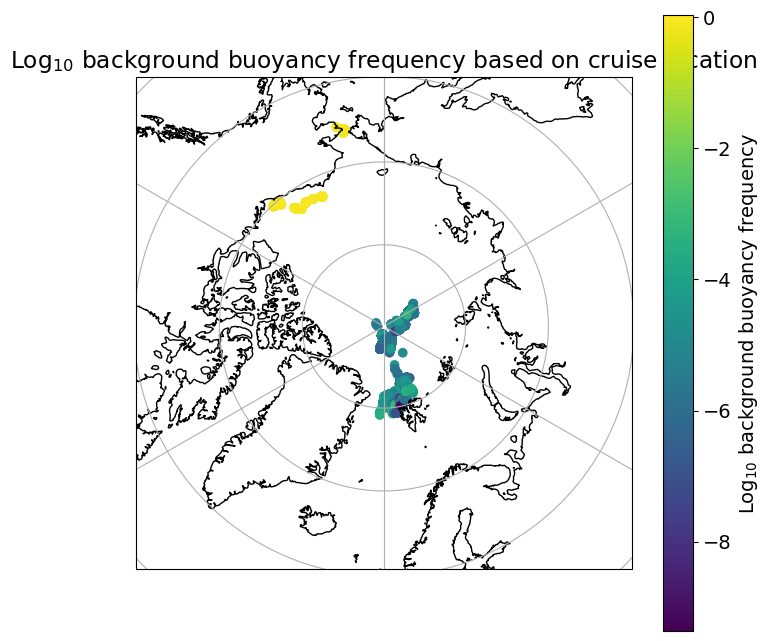

In [23]:
stereo_plot(arctic_df, arctic_df["log_N2"], "Log$_{10}$ background buoyancy frequency")

## Cruise plot

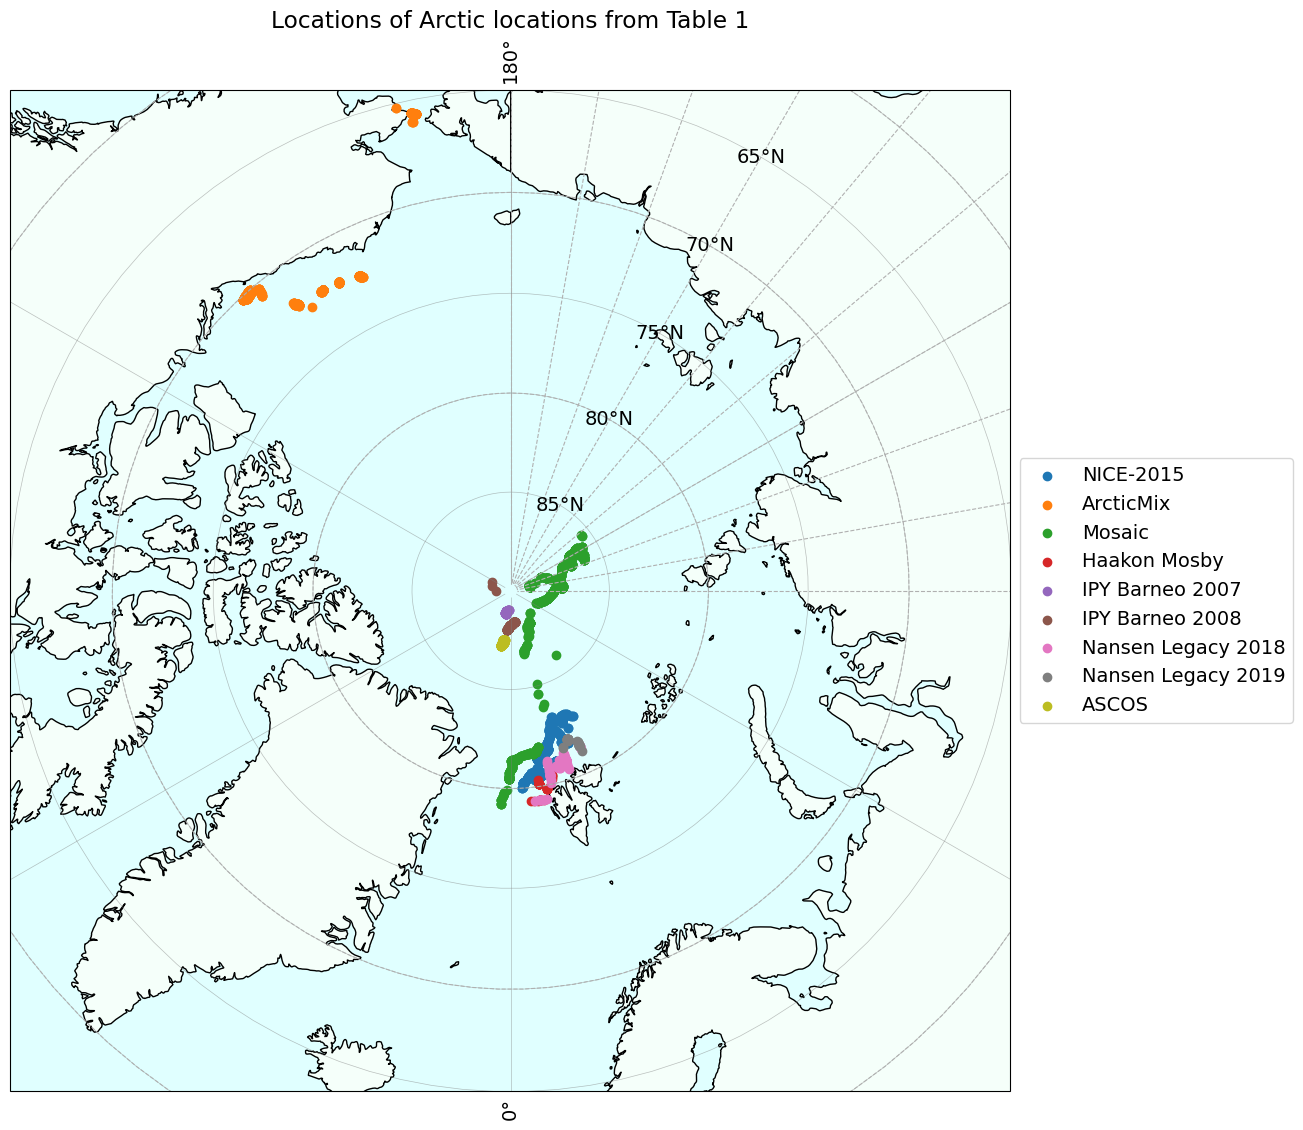

In [59]:
import matplotlib.colors as mcolors
import itertools
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def stereo_cruise_plot(merged_df):
    # Create a polar stereographic projection centered on the Arctic pole
    projection = ccrs.NorthPolarStereo(central_longitude=0)

    # Get unique cruise names and assign a unique color to each name
    cruise_names = merged_df['cruise'].unique()
    colors = itertools.cycle(mcolors.TABLEAU_COLORS)

    # Create a figure and axes using the polar stereographic projection
    fig, ax = plt.subplots(figsize=(13, 13), subplot_kw={'projection': projection})

    # Plot the ocean as light blue
    ax.add_feature(cfeature.OCEAN, facecolor='lightcyan', edgecolor='black')

    # Plot the land as light green
    ax.add_feature(cfeature.LAND, facecolor='mintcream', edgecolor='black')

    # Plot longitude and latitude with colored residuals based on cruise name
    for cruise in cruise_names:
        cruise_data = merged_df[merged_df['cruise'] == cruise]
        color = next(colors)
        sc = ax.scatter(cruise_data['longitude'], cruise_data['latitude'],
                        color=color, label=cruise, transform=ccrs.PlateCarree())

    # Set map extent to focus on the Arctic region
    ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())

    # Add gridlines with latitude and longitude labels
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    ax.gridlines(xlocs=range(90, 271, 10), ylocs=range(60, 91, 10), linestyle='--')

    # Set plot title and labels
    plt.title("Locations of Arctic locations from Table 1")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Place the legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

stereo_cruise_plot(arctic_df)

In [72]:
# make sure for all depths
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/1906_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

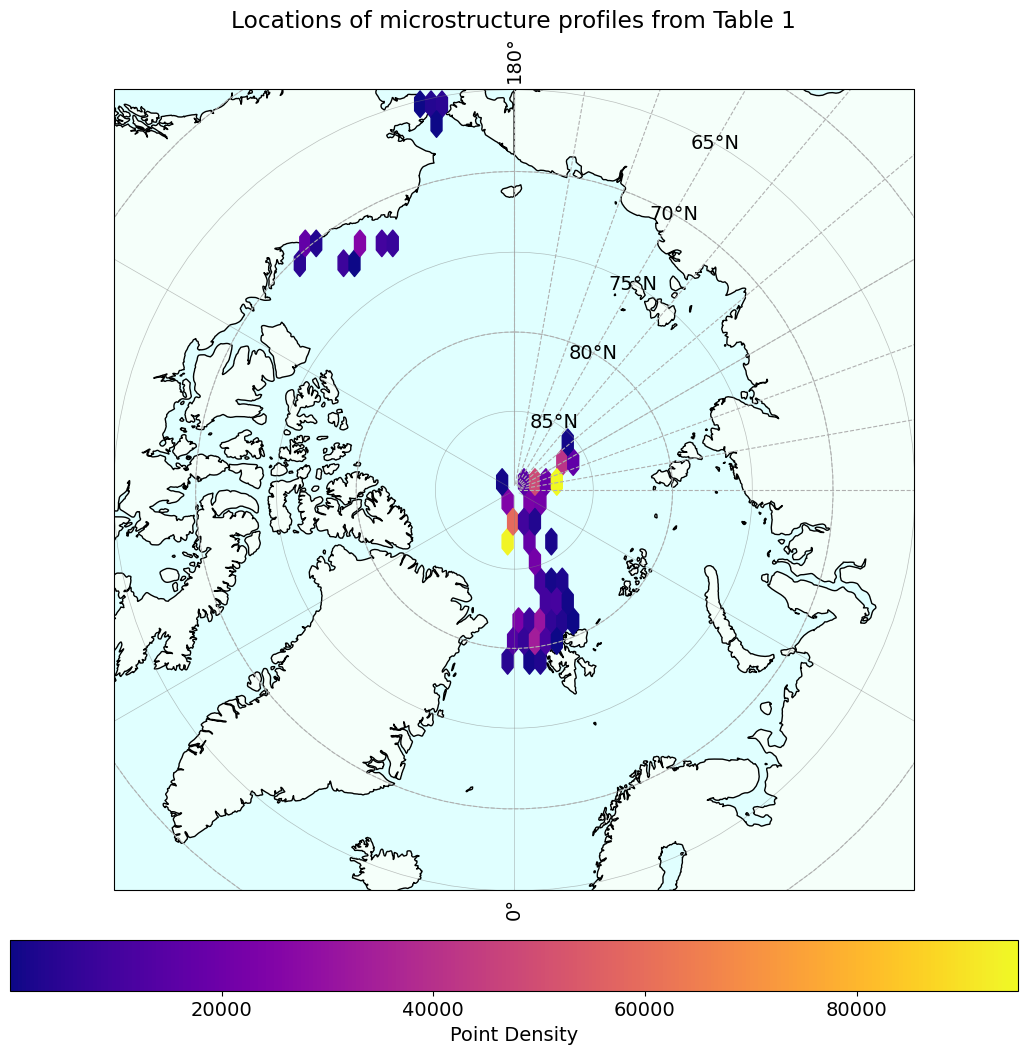

In [73]:
def pointdensity_cruise_plot(merged_df):
    # Create a polar stereographic projection centered on the Arctic pole
    projection = ccrs.NorthPolarStereo(central_longitude=0)

    # Get unique cruise names and assign a unique color to each name
    cruise_names = merged_df['cruise'].unique()
    colors = itertools.cycle(mcolors.TABLEAU_COLORS)

    # Create a figure and axes using the polar stereographic projection
    fig, ax = plt.subplots(figsize=(13, 13), subplot_kw={'projection': projection})

    # Plot the ocean as light blue
    ax.add_feature(cfeature.OCEAN, facecolor='lightcyan', edgecolor='black')

    # Plot the land as light green
    ax.add_feature(cfeature.LAND, facecolor='mintcream', edgecolor='black')

    # Compute point density using hexbin
    hb = ax.hexbin(
        merged_df['longitude'], merged_df['latitude'], gridsize=25,
        cmap='plasma', transform=ccrs.PlateCarree(), mincnt=1
    )

    # Get the counts and bin locations from the hexbin object
    counts = hb.get_array()
    x = hb.get_offsets()[:, 0]
    y = hb.get_offsets()[:, 1]

    # Set transparency for bins with count 0
    cmap = plt.cm.get_cmap('Blues')
    cmap.set_under(alpha=0)

    # Plot the hexbin points with transparency based on counts
    ax.scatter(
        x, y, c=counts, cmap=cmap, alpha=0.8, transform=ccrs.PlateCarree()
    )

    # Set map extent to focus on the Arctic region
    ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())

    # Add gridlines with latitude and longitude labels
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    ax.gridlines(xlocs=range(90, 271, 10), ylocs=range(60, 91, 10), linestyle='--')

    # Set plot title and labels
    plt.title("Locations of microstructure profiles from Table 1")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add colorbar for point density
    cbar = plt.colorbar(hb, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Point Density')

    # Show the plot
    plt.show()

pointdensity_cruise_plot(arctic_df)

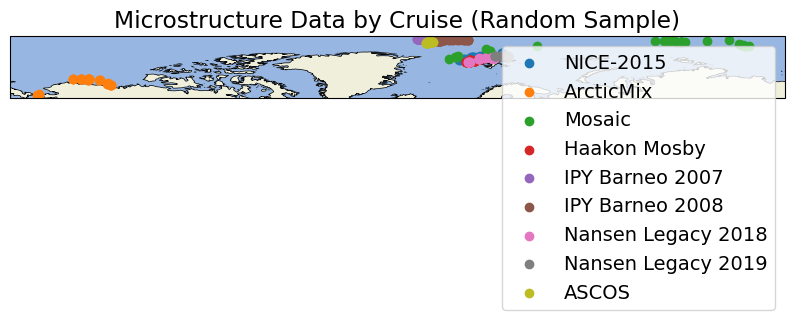

In [77]:
full_df = pd.read_pickle(os.path.join(parent_dir, "data/processed/ml_ready/1906_time.pkl"))
# full_df = pd.read_pickle("/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed/ml_ready/1406_ML.pkl")
full_df.cruise.unique()

import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the number of points to sample per cruise
num_points_per_cruise = 30

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Iterate over each unique cruise
for cruise in full_df["cruise"].unique():
    cruise_data = full_df[full_df["cruise"] == cruise]
    
    # Check if the number of data points is less than the desired sample size
    if len(cruise_data) < num_points_per_cruise:
        # If fewer points, include all data points
        sampled_data = pd.concat([sampled_data, cruise_data])
    else:
        # If enough points, randomly sample the desired number
        sampled_data = pd.concat([sampled_data, cruise_data.sample(n=num_points_per_cruise, random_state=42)])

# Define a color palette for each cruise
cruise_palette = plt.cm.tab10(range(len(full_df["cruise"].unique())))

# Define the projection
projection = ccrs.PlateCarree()

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Create a scatter plot with different colored cruises
for cruise, color in zip(sampled_data["cruise"].unique(), cruise_palette):
    cruise_data = sampled_data[sampled_data["cruise"] == cruise]
    ax.scatter(cruise_data["longitude"], cruise_data["latitude"], label=cruise, color=color, transform=projection)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Microstructure Data by Cruise (Random Sample)')
ax.legend()
plt.show()


## Explore how much of each

In [8]:
full_df = pd.read_pickle(os.path.join(parent_dir, "data/processed/ml_ready/1906_time.pkl"))
# full_df = pd.read_pickle("/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed/ml_ready/1406_ML.pkl")
unique_latitudes_df = full_df[~full_df.duplicated(subset="latitude")]
full_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby',
       'IPY Barneo 2007', 'IPY Barneo 2008', 'Nansen Legacy 2018',
       'Nansen Legacy 2019', 'ASCOS'], dtype=object)

## Data distribution

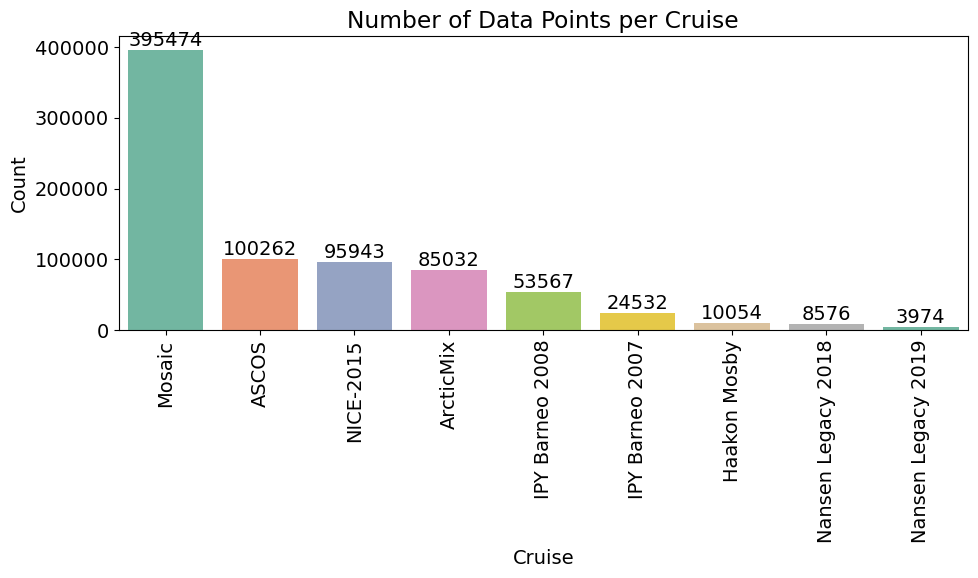

In [75]:
import seaborn as sns

# Count the data points for each cruise
cruise_counts = full_df["cruise"].value_counts()

# Set a custom color palette
colors = sns.color_palette('Set2')

# Plot the cruise counts with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x=cruise_counts.index, y=cruise_counts.values, palette=colors)
plt.xlabel('Cruise')
plt.ylabel('Count')
plt.title('Number of Data Points per Cruise')

# Add count labels on top of each bar
for i, count in enumerate(cruise_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

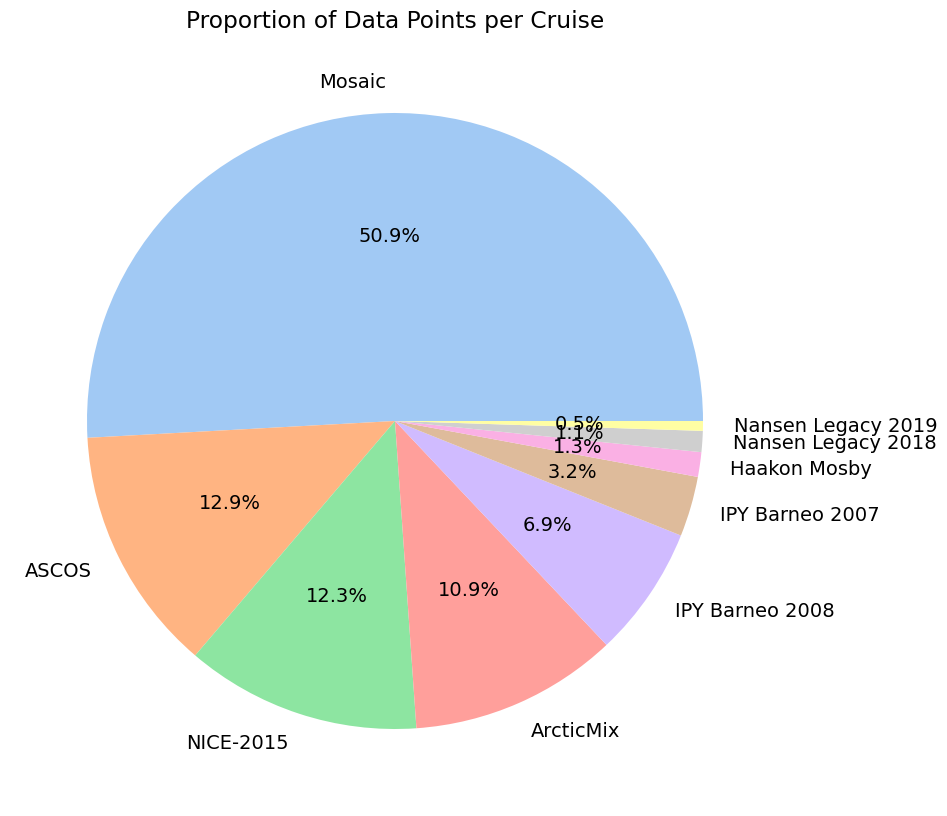

In [76]:
import seaborn as sns
# Calculate the proportions of data points for each cruise
cruise_proportions = full_df["cruise"].value_counts(normalize=True)

# Create a pie chart using Matplotlib with a Seaborn color palette
plt.figure(figsize=(10, 10))
colors = sns.color_palette("pastel")
plt.pie(cruise_proportions, labels=cruise_proportions.index, autopct='%1.1f%%', colors=colors)
plt.title('Proportion of Data Points per Cruise')
plt.show()

## Distribution weighed by depth

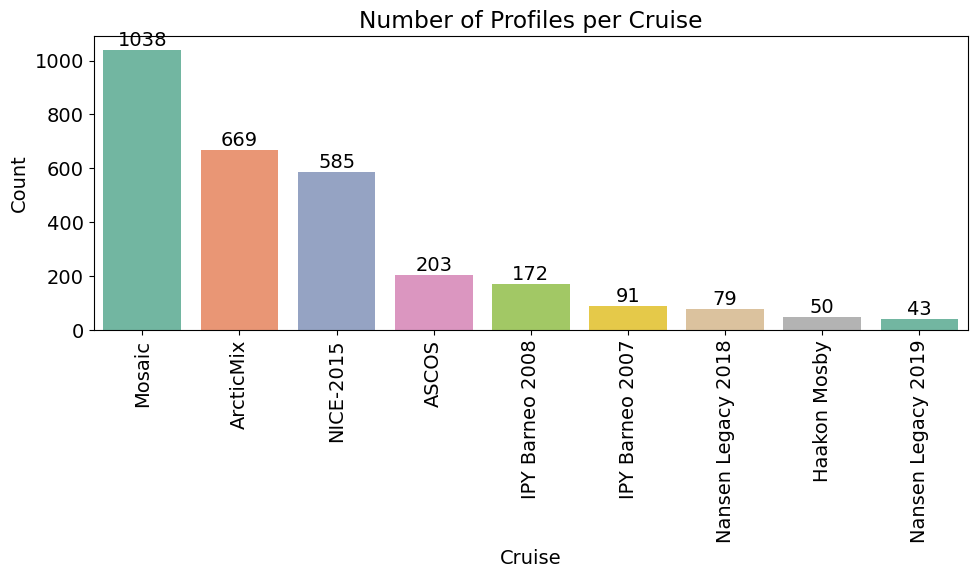

In [9]:
# weighed by depth indices

import matplotlib.pyplot as plt
import seaborn as sns

# Count the data points for each cruise
# Filter for unique latitude points
cruise_counts = unique_latitudes_df["cruise"].value_counts()

# Set a custom color palette
colors = sns.color_palette('Set2')

# Plot the cruise counts with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x=cruise_counts.index, y=cruise_counts.values, palette=colors)
plt.xlabel('Cruise')
plt.ylabel('Count')
plt.title('Number of Profiles per Cruise')

# Add count labels on top of each bar
for i, count in enumerate(cruise_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

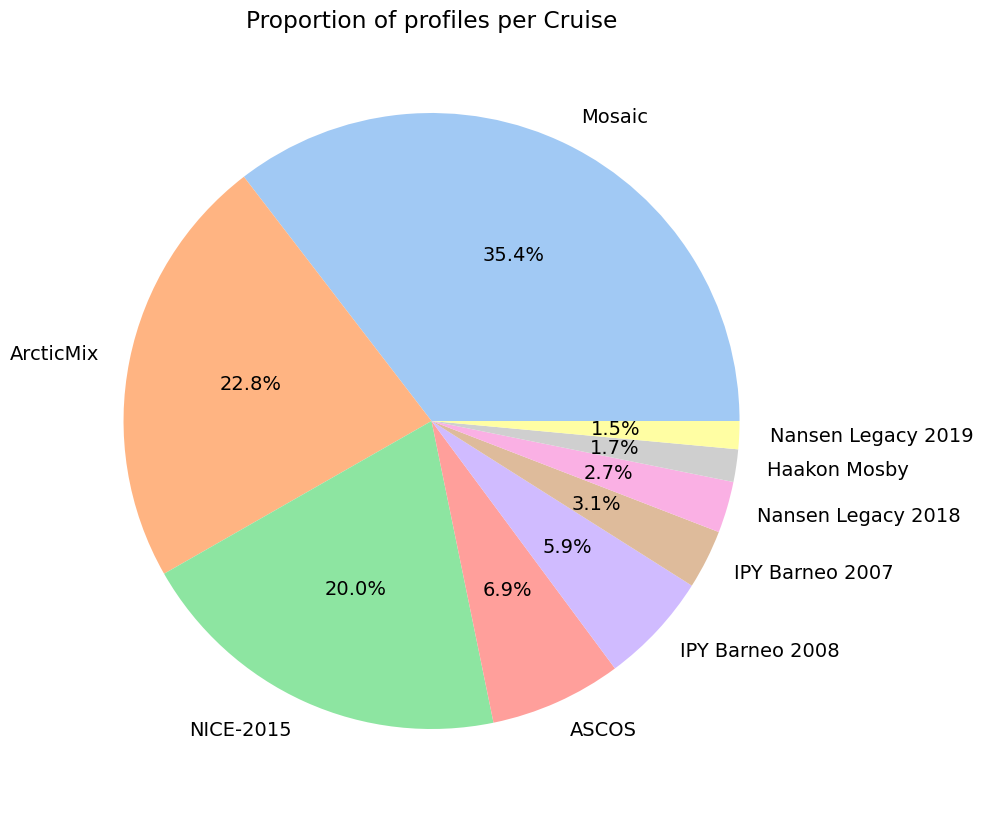

In [10]:
import seaborn as sns
# Calculate the proportions of data points for each cruise
cruise_proportions = unique_latitudes_df["cruise"].value_counts(normalize=True)

# Create a pie chart using Matplotlib with a Seaborn color palette
plt.figure(figsize=(10, 10))
colors = sns.color_palette("pastel")
plt.pie(cruise_proportions, labels=cruise_proportions.index, autopct='%1.1f%%', colors=colors)
plt.title('Proportion of profiles per Cruise')
plt.show()

# Evaluate depth

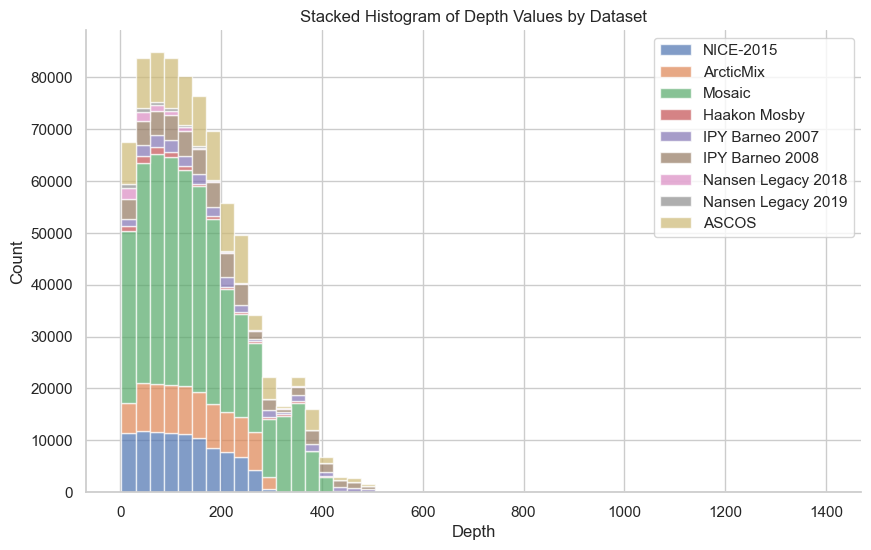

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up Seaborn style
sns.set(style='whitegrid')

# Define the depth values and cruise labels
depth_values = [full_df.loc[full_df['cruise'] == cruise, 'depth'] for cruise in full_df['cruise'].unique()]
labels = full_df['cruise'].unique()

# Plot a stacked histogram with labeled bars
plt.figure(figsize=(10, 6))
plt.hist(depth_values, bins=50, stacked=True, label=labels, alpha=0.7)

plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Stacked Histogram of Depth Values by Dataset')
plt.legend()

# Remove the right and top spines
sns.despine()

# Display the plot
plt.show()

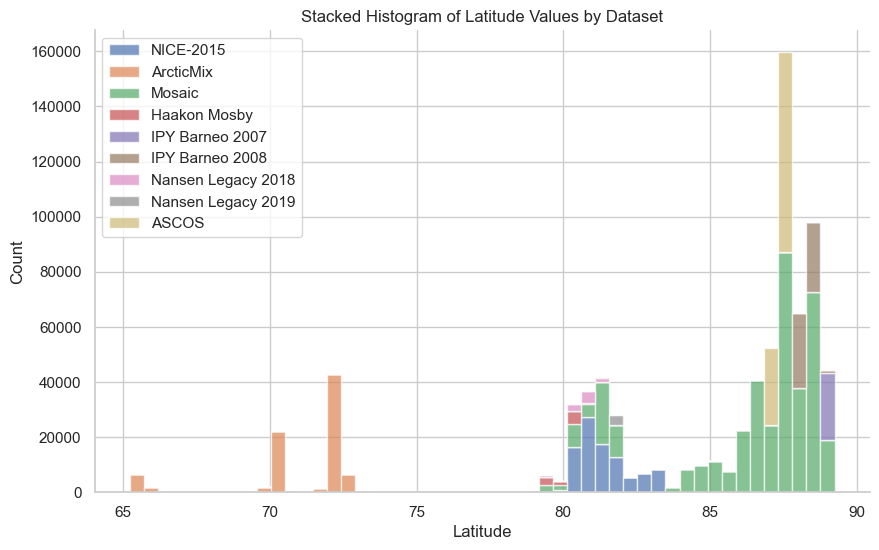

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up Seaborn style
sns.set(style='whitegrid')

# Define the latitude values and cruise labels
latitude_values = [full_df.loc[full_df['cruise'] == cruise, 'latitude'] for cruise in full_df['cruise'].unique()]
labels = full_df['cruise'].unique()

# Plot a stacked histogram with labeled bars
plt.figure(figsize=(10, 6))
plt.hist(latitude_values, bins=50, stacked=True, label=labels, alpha=0.7)

plt.xlabel('Latitude')
plt.ylabel('Count')
plt.title('Stacked Histogram of Latitude Values by Dataset')
plt.legend()

# Remove the right and top spines
sns.despine()

# Display the plot
plt.show()